## WIS - CDIP Comparisons: Plot Parameters
Test script does the following:
* Load WIS NetCDF data from FRF THREDDS server
* Create figure of WIS output at CDIP buoy locations

### Initialize variables
Enter NDBC/CDIP buoy information and start/end dates

In [6]:
ndbc_id = '44098'             #- 160- jeffrey's Ledge
cdip_id = '160'
buoy_name = 'Jeffreys Ledge'
region = 'Atlantic'

start_date = '20080901'
end_date = '20080930'
year = start_date[0:4]
month = start_date[4:6]
day = start_date[6:8]

### Import Python libraries

In [31]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mat_dates
%matplotlib inline
import datetime
import time
import calendar

### Load WIS data from FRF Thredds server
Supply url and file and utilize NetCDF4 library to output a variable called 'nc' with WIS data

In [8]:
wis_url = 'https://chlthredds.erdc.dren.mil/thredds/dodsC/wis/'+ \
          region+'/ST'+ndbc_id+'/'+year+'/'
nc_file = 'WIS-ocean_waves_ST'+ndbc_id+'_'+year+month+'.nc'
nc = netCDF4.Dataset(wis_url+nc_file)


Return a list of variable names contained in NetCDF file

In [26]:
wis_vars = nc.variables.keys()
print('Variable Names:')
for i in wis_vars:
    print("\t"+i)

Variable Names:
	station_name
	lon
	lat
	waveHsWindsea
	waveSpreadWindsea
	waveTm2Windsea
	waveHs
	waveMeanDirection
	waveTm1Windsea
	frictionalVelocity
	waveTpPeakSwell
	waveMeanDirectionSwell
	waveTpPeakWindsea
	waveSpread
	waveSpreadSwell
	waveTmWindsea
	waveDirectionBins
	waveTpPeak
	waveTmSwell
	waveTm2Swell
	waveTpWindsea
	waveStress
	coefficientOfDrag
	waveTm1Swell
	waveTpSwell
	windDirection
	waveTm1
	waveFrequency
	waveTm2
	waveMeanDirectionWindsea
	waveTp
	waveHsSwell
	windSpeed
	waveTm
	time
	directionalWaveEnergyDensity


Set a few variables of wave parameters we are interested in

In [14]:
unix_time = nc.variables['time'][:] 	# seconds since 1970-01-01 00:00:00 UTC
Hs = nc.variables['waveHs']
Tp = nc.variables['waveTp']
Dp = nc.variables['waveMeanDirection'] 

### Convert unix time to datetime object
From metadata, time data are stored as UNIX timestamps (values are in seconds since 01-01-1970 00:00:00). The below line is the 'pythonic' equivalent of a one-line 'for loop' which iteratively converts unix_time to an array of datetime objects called wave_time. 

In [15]:
wave_time = [datetime.datetime.fromtimestamp(t) for t in unix_time]

Define two functions: 
* get_timestamp: to convert iso-time to timestamp 
* find_nearest: to find nearest value in numpy array

In [28]:
# Function to convert from human-format to UNIX timestamp
def get_timestamp(humanTime,dateFormat):
    unixTimestamp = int(time.mktime(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unixTimestamp

# Function to find nearest value in numpy array
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


### Time index values
Get time indices: That is, find the locations of UNIX timestamp values in netcdf file that correspond to Start and End dates/times.
Note: this isn't important in small time-series, however necessary when netcdf file is huge time-series and we are only interested in subset of data.

In [32]:
#- Find index of start_date
unix_start = get_timestamp(start_date,"%Y%m%d") 
nearest_start = find_nearest(unix_time, unix_start)
start_index = np.where(unix_time==nearest_start)[0][0]  
#- Find index of end_date
unix_end = get_timestamp(end_date,"%Y%m%d")
future = find_nearest(unix_time, unix_end)  
end_index = np.where(unix_time==future)[0][0]

### Plot wave parameters
Utilize matplotlib (python lib) to create a figure with:
* Three subplots (pHs, pTp, pDp) with shared x-axis
* Additional axis parameters/labels/grids for readability

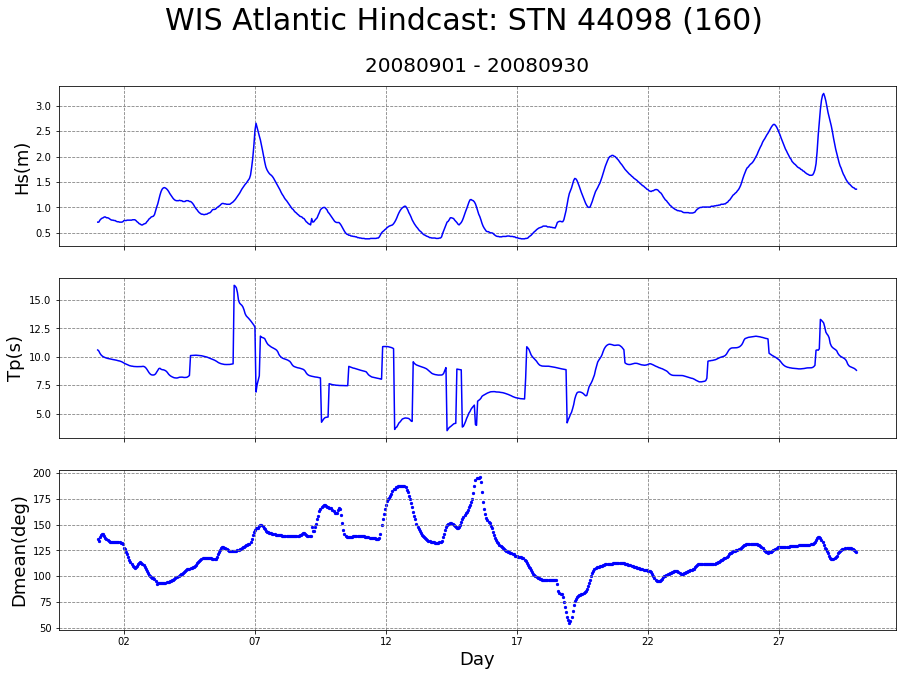

In [40]:
#- Plot wave bulk parameters 
# Create figure and specify subplot orientation (3 rows, 1 column), shared x-axis
f, (pHs, pTp, pDp) = plt.subplots(3, 1, sharex=True, figsize=(15,10))
# Create 3 stacked subplots for three PARAMETERS (Hs, Tp, Dp)
pHs.plot(wave_time[start_index:end_index],Hs[start_index:end_index],'b')
pTp.plot(wave_time[start_index:end_index],Tp[start_index:end_index],'b')
pDp.scatter(wave_time[start_index:end_index],Dp[start_index:end_index],color='blue',s=5) 
#- figure title(s)
plot_title = nc.title+': STN '+ndbc_id+' ('+cdip_id+')' 
plt.suptitle(plot_title, fontsize=30, y=0.99)
plt.title(start_date + " - " + end_date, fontsize=20, y=3.45)
# Label each y-axis
pHs.set_ylabel('Hs(m)', fontsize=18) 
pTp.set_ylabel('Tp(s)', fontsize=18)
pDp.set_ylabel('Dmean(deg)', fontsize=18);
# Set x-axis tick interval to every 5 days
days = mat_dates.DayLocator(interval=5) 
daysFmt = mat_dates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(daysFmt)
# Label x-axis
plt.xlabel('Day', fontsize=18)
# Plot dashed gridlines
pHs.grid(b=True, which='major', color='gray', linestyle='--')
pTp.grid(b=True, which='major', color='gray', linestyle='--')
pDp.grid(b=True, which='major', color='gray', linestyle='--');
